# Importing important libraries

In [1]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Main Code Block

In [2]:
class COCOVisualizer:
    def __init__(self, annotations_file, images_dir):
        """
        Initialize the COCO visualizer
        
        Args:
            annotations_file (str): Path to COCO JSON annotations file
            images_dir (str): Path to directory containing images
        """
        self.images_dir = Path(images_dir)
        with open(annotations_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create category ID to name mapping
        self.cat_id_to_name = {
            cat['id']: cat['name'] 
            for cat in self.coco_data['categories']
        }
        
        # Create filename to image info mapping
        self.filename_to_info = {
            img['file_name']: img 
            for img in self.coco_data.get('images', [])
        }
        
        # Generate random colors for each category
        random.seed(42)  # For consistent colors
        self.category_colors = {
            cat_id: (random.randint(0, 255), 
                    random.randint(0, 255), 
                    random.randint(0, 255))
            for cat_id in self.cat_id_to_name.keys()
        }

    def draw_bbox(self, image, bbox, color):
        """Draw a bounding box on the image"""
        x, y, w, h = [int(coord) for coord in bbox]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        return image

    def draw_segmentation(self, image, segmentation, color):
        """Draw segmentation polygons on the image"""
        for segment in segmentation:
            # Convert segment points to numpy array of integers
            points = np.array(segment).reshape(-1, 2).astype(np.int32)
            cv2.polylines(image, [points], True, color, 2)
            # Fill polygon with semi-transparent color
            overlay = image.copy()
            cv2.fillPoly(overlay, [points], color)
            cv2.addWeighted(overlay, 0.3, image, 0.7, 0, image)
        return image

    def visualize_image_by_filename(self, filename, show_bbox=True, show_segmentation=True, show_labels=True):
        """
        Visualize annotations for a specific image file
        
        Args:
            filename (str): Image filename to visualize
            show_bbox (bool): Whether to show bounding boxes
            show_segmentation (bool): Whether to show segmentation masks
            show_labels (bool): Whether to show category labels
        """
        if filename not in self.filename_to_info:
            raise ValueError(f"Image {filename} not found in annotations")
            
        # Get image info and read image
        image_info = self.filename_to_info[filename]
        image_path = self.images_dir / filename
        
        if not image_path.exists():
            raise ValueError(f"Image file not found: {image_path}")
            
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find annotations for this image
        annotations = [
            ann for ann in self.coco_data['annotations']
            if ann['image_id'] == image_info['id']
        ]
        
        # Draw annotations
        for ann in annotations:
            category_id = ann['category_id']
            color = self.category_colors[category_id]
            
            # Draw segmentation if present and requested
            if show_segmentation and 'segmentation' in ann:
                image = self.draw_segmentation(image, ann['segmentation'], color)
            
            # Draw bbox if requested
            if show_bbox and 'bbox' in ann:
                image = self.draw_bbox(image, ann['bbox'], color)
            
            # Add label if requested
            if show_labels and 'bbox' in ann:
                x, y = ann['bbox'][:2]
                label = self.cat_id_to_name[category_id]
                cv2.putText(image, label, (int(x), int(y) - 10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        return image

    def show_image(self, filename, figsize=(15, 10)):
        """Display the annotated image"""
        image = self.visualize_image_by_filename(filename)
        plt.figure(figsize=figsize)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def list_images(self):
        """List all available image filenames"""
        return sorted(self.filename_to_info.keys())

    def show_random_samples(self, num_samples=4, figsize=(15, 15)):
        """Display random sample images with annotations"""
        filenames = list(self.filename_to_info.keys())
        samples = random.sample(filenames, min(num_samples, len(filenames)))
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.ravel()
        
        for idx, filename in enumerate(samples):
            if idx < len(axes):
                image = self.visualize_image_by_filename(filename)
                axes[idx].imshow(image)
                axes[idx].axis('off')
                axes[idx].set_title(f'Image: {filename}')
        
        plt.tight_layout()
        plt.show()


# Show Random Images from a folder

Available images:
['000818da-15_jpg.rf.08062e734646c2db2199600233a0721c.jpg', '004db5de-29_jpg.rf.1eb77dd1388d38e4ec070ed5af02213b.jpg', '008b1585-22_jpg.rf.3d75500f01cc54ef79b49c6459960a23.jpg', '016f2c9f-23_jpg.rf.1a4a75527269088c9a602e908ed7acb9.jpg', '0180e13d-28_jpg.rf.ccf204d241ef4bba9e33229f1f830530.jpg', '027e3502-37_jpg.rf.fb6500b9661af7d289fe1bdaae10d524.jpg', '029db473-12_jpg.rf.c401eb86d213b0b2734cc311ad2836bd.jpg', '02f89cf3-30_jpg.rf.0f7f2a4596ddacfff7460eb44e0a14e4.jpg', '03110421-16_jpg.rf.079b1e13e72cf637d0f8e12543e3db0b.jpg', '0381a4f2-27_jpg.rf.4a82f4a59bf4dccca065b9b9a12992b8.jpg', '046fd78d-10_jpg.rf.522653874bb8024aca596b9261bc40d1.jpg', '04e6b4f3-27_jpg.rf.9c2b58930d8d666d8aac84683b5ca303.jpg', '0572df54-23_jpg.rf.9ed339c5c045ab76cacc982529fe055b.jpg', '0605a62b-13_jpg.rf.1771071294f701036c2e32d01b2b1bcf.jpg', '0721cbc6-15_jpg.rf.062563a984531b89b67f5d22e6fa3366.jpg', '0759c32c-18_jpg.rf.240045a69ef4dd25d106aa6a040f923a.jpg', '07d90d55-35_jpg.rf.f97820d89280f5655

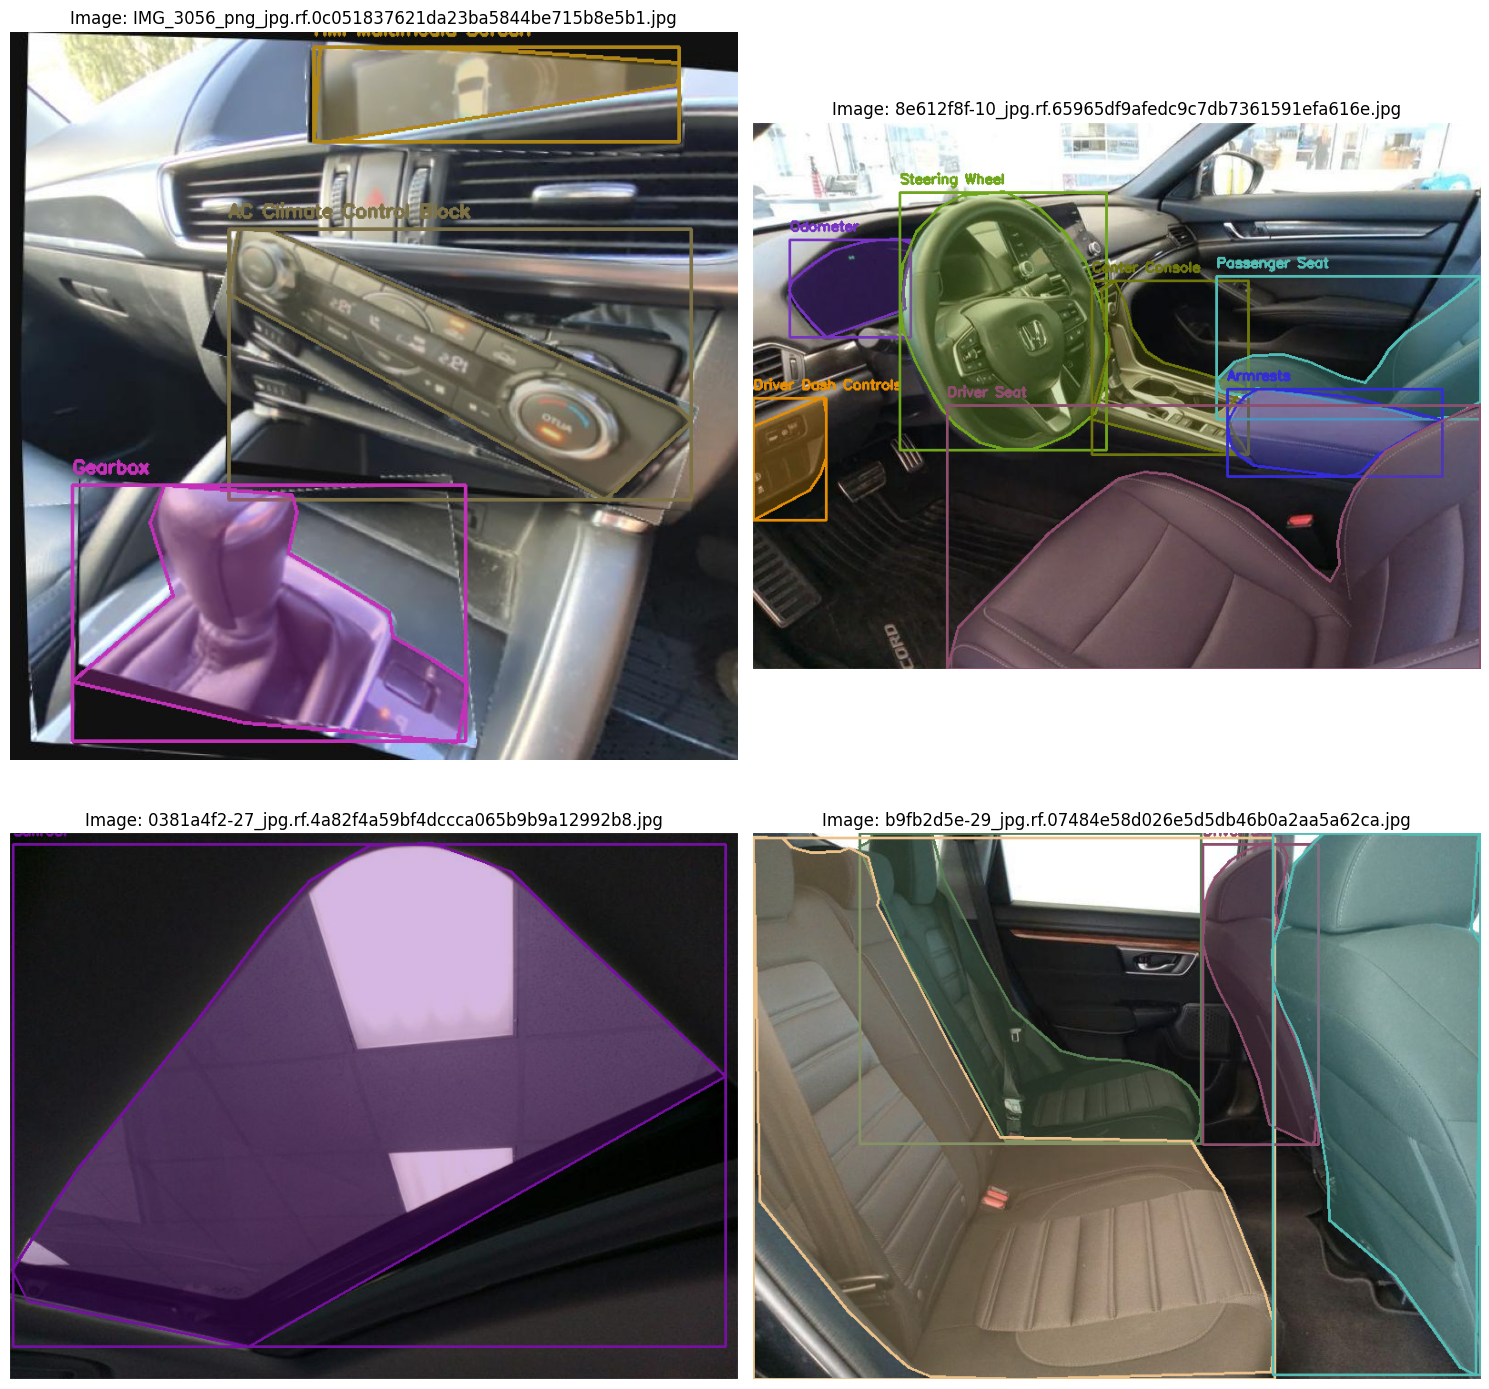

In [3]:
# Example usage
if __name__ == "__main__":
    visualizer = COCOVisualizer(
        annotations_file='./annotations/modified_annotations.json',
        images_dir='./images'
    )
    
    # List available images
    print("Available images:")
    print(visualizer.list_images())
        
    # Or show random samples
    visualizer.show_random_samples()

# Show a Specific Image in a Folder

Available images:
['000818da-15_jpg.rf.08062e734646c2db2199600233a0721c.jpg', '004db5de-29_jpg.rf.1eb77dd1388d38e4ec070ed5af02213b.jpg', '008b1585-22_jpg.rf.3d75500f01cc54ef79b49c6459960a23.jpg', '016f2c9f-23_jpg.rf.1a4a75527269088c9a602e908ed7acb9.jpg', '0180e13d-28_jpg.rf.ccf204d241ef4bba9e33229f1f830530.jpg', '027e3502-37_jpg.rf.fb6500b9661af7d289fe1bdaae10d524.jpg', '029db473-12_jpg.rf.c401eb86d213b0b2734cc311ad2836bd.jpg', '02f89cf3-30_jpg.rf.0f7f2a4596ddacfff7460eb44e0a14e4.jpg', '03110421-16_jpg.rf.079b1e13e72cf637d0f8e12543e3db0b.jpg', '0381a4f2-27_jpg.rf.4a82f4a59bf4dccca065b9b9a12992b8.jpg', '046fd78d-10_jpg.rf.522653874bb8024aca596b9261bc40d1.jpg', '04e6b4f3-27_jpg.rf.9c2b58930d8d666d8aac84683b5ca303.jpg', '0572df54-23_jpg.rf.9ed339c5c045ab76cacc982529fe055b.jpg', '0605a62b-13_jpg.rf.1771071294f701036c2e32d01b2b1bcf.jpg', '0721cbc6-15_jpg.rf.062563a984531b89b67f5d22e6fa3366.jpg', '0759c32c-18_jpg.rf.240045a69ef4dd25d106aa6a040f923a.jpg', '07d90d55-35_jpg.rf.f97820d89280f5655

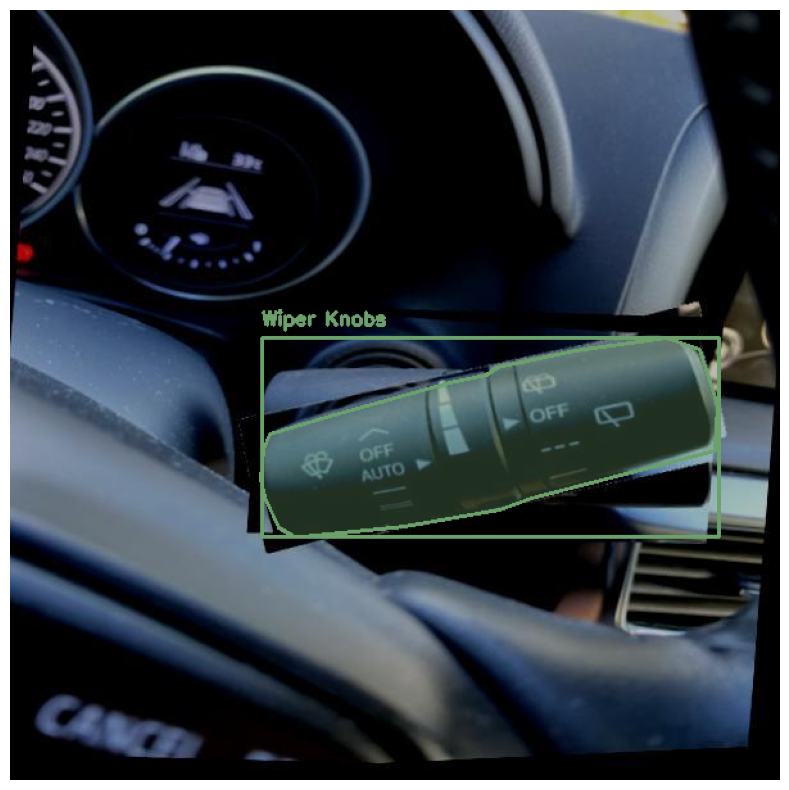

In [4]:
# Example usage
if __name__ == "__main__":
    visualizer = COCOVisualizer(
        annotations_file='./annotations/modified_annotations.json',
        images_dir='./images'
    )
    
    # List available images
    print("Available images:")
    print(visualizer.list_images())
    
    # Show specific image
    visualizer.show_image('IMG_3129_png_jpg.rf.d9855e78ec1d9c8adde9a7982257bafe.jpg')